#LEXMERT, F-RCNN e NMT

Nel modello LXMERT proposto da Hao Tan & Mohit Bansal LXMERT: Learning Cross-Modality Encoder Representations from Transformers) si utilizzano una serie di architetture di tipo transformer per Q&A visuale (ossia basata su immagini). Si tratta di tre reti neurali: una per la modalità visuale, una per la modalità NLP e la terza per sintetizzare le prime 2.

## Demo ##
In questo notebook vediamo come usare una rete LXMERT con una rete FRCNN ed una rete per la neural translation per convertire il tutto in lingua italiana. Dal lavoro congiunto delle tre reti alla fine otterremo un sistema che risponde a domande relative ad un immagine. In questo notebook non addestriamo nessuna rete ma utilizziamo reti preaddestrate per fare un lavoro congiunto!

Nota: Questo notebook è un fork, poi modificato da me di un altro notebook che ho trovato su twitter, ma non ricordo l'autore :-(.

Cloniamo la repository per poter accedere ai moduli necessari

In [ ]:
!git clone https://github.com/huggingface/transformers
%cd transformers/examples/lxmert

Iniziamo con l'installare le librerie necessarie:

In [ ]:
!pip install transformers
!pip install wget

Adesso importiamo le librerie e facciamo un test:

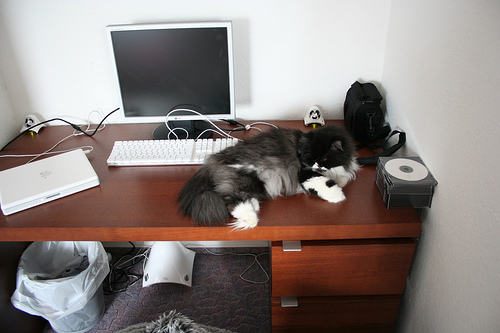

In [ ]:
from IPython.display import clear_output, Image, display
import PIL.Image
import io
import json
import torch
import numpy as np
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from utils import Config
import utils
from transformers import LxmertForQuestionAnswering, LxmertTokenizer
import wget
import pickle
import os

URL = "https://vqa.cloudcv.org/media/test2014/COCO_test2014_000000262567.jpg"
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

display(Image(URL))    

#for visualizing output
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

Carichiamo oggetti, attributi e risposte

In [ ]:
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
vqa_answers = utils.get_data(VQA_URL)

Carichiamo i modelli

In [ ]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")
lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased")

Eseguiamo un inferenza sulla rete frcnn con l'immagine scaricata

In [ ]:
#image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)
# run frcnn
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images, 
    sizes, 
    scales_yx=scales_yx, 
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt"
)
#add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)

Normalizziamo i bounding box dell'immagine

In [ ]:
#Boxes need to be normalized
normalized_boxes = output_dict.get("normalized_boxes")
features = output_dict.get("roi_features")

Siccome LXMERT è addestrato per funzionare in lingua inglese, carichiamo un rete per la traduzione dall'italiano all'inglese e viceversa e definiamo due funzioni per la traduzione

In [ ]:
#Now in Italian: Ora in italiano
from transformers import MarianTokenizer, MarianMTModel
from typing import List

model_iten = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-it-en")
tok_iten = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-it-en")

model_enit = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-it")
tok_enit = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-it")

def it2en(text):
  batch = tok_iten.prepare_seq2seq_batch(src_texts=[text])
  gen = model_iten.generate(**batch)
  words: List[str] = tok_iten.batch_decode(gen, skip_special_tokens=True) 
  return words

def en2it(text):
  batch = tok_enit.prepare_seq2seq_batch(src_texts=[text])
  gen = model_enit.generate(**batch)
  words: List[str] = tok_enit.batch_decode(gen, skip_special_tokens=True) 
  return words

Definiamo le domande da sottoporre al modello

In [ ]:
domande = ["è presente un gatto?",
           "è presente un cane?",
           "dove è il gatto?",
           "Cosa c'è vicino il disco?",
           "Di che colore è il tavolo?",
           "Di che colore è il gatto",
           "Di che colore è il cestino della spazzatura?",
           "Il cestino della spazzatura è pieno o vuoto?",
           "Il cestino della spazzatura è pieno?",
           "Il cestino della spazzatura è vuoto?",
           "Che forma ha il monitor?"]

Siamo pronti per testare il nostro modello (per maggiore chiarezza stampiamo  le domande in italiano che in inglese)

In [ ]:
for test_question in domande:
    # run lxmert
    d = test_question
    test_question = it2en(test_question)
    print(test_question)
    #test_question = [test_question]

    inputs = lxmert_tokenizer(
        test_question,
        padding="max_length",
        max_length=20,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt"
    )

    # run lxmert(s) 
    output_vqa = lxmert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_feats=features,
        visual_pos=normalized_boxes,
        token_type_ids=inputs.token_type_ids,
        return_dict=True,
        output_attentions=False,
    )
    # get prediction
    pred_vqa = output_vqa["question_answering_score"].argmax(-1)   
    print("Domanda:", d)    
    print("prediction from LXMERT VQA:", en2it(vqa_answers[pred_vqa]))

['Is there a cat?']
Domanda: è presente un gatto?
prediction from LXMERT VQA: ['sì']
['Is there a dog?']
Domanda: è presente un cane?
prediction from LXMERT VQA: ['no']
["Where's the cat?"]
Domanda: dove è il gatto?
prediction from LXMERT VQA: ['scrivania']
["What's next to the disc?"]
Domanda: Cosa c'è vicino il disco?
prediction from LXMERT VQA: ['topo']
['What color is the table?']
Domanda: Di che colore è il tavolo?
prediction from LXMERT VQA: ['marrone']
['What color is the cat?']
Domanda: Di che colore è il gatto
prediction from LXMERT VQA: ['bianco e nero']
['What color is the garbage basket?']
Domanda: Di che colore è il cestino della spazzatura?
prediction from LXMERT VQA: ['bianco']
['Is the garbage basket full or empty?']
Domanda: Il cestino della spazzatura è pieno o vuoto?
prediction from LXMERT VQA: ['pieno']
['Is the garbage basket full?']
Domanda: Il cestino della spazzatura è pieno?
prediction from LXMERT VQA: ['sì']
['Is the garbage basket empty?']
Domanda: Il cestino